Missing values before cleaning:
Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64

Infinite values before cleaning:
Distance                      0
Delivery_Person_Experience    0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64

Naive Bayes Classifier


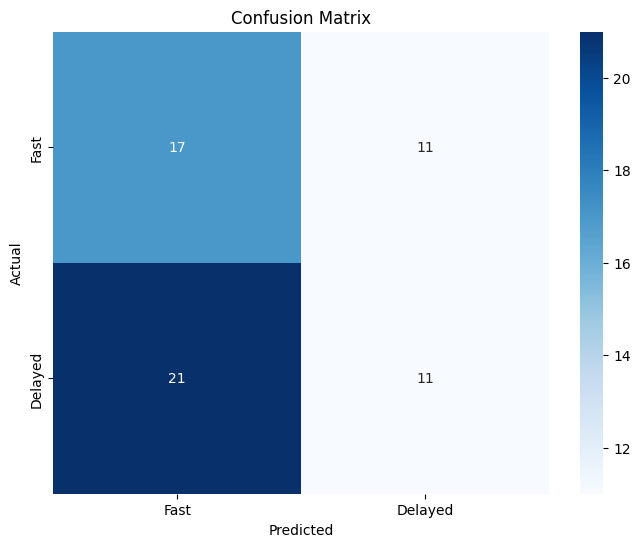

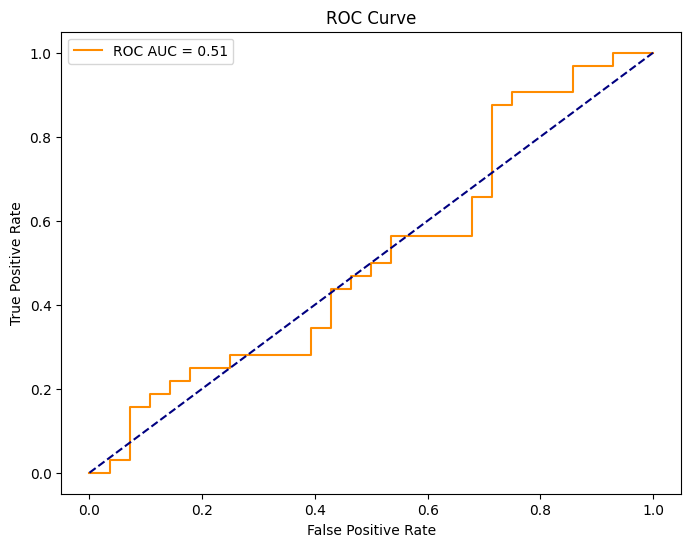

Accuracy: 0.4667
Precision: 0.5000
Recall: 0.3438
F1 Score: 0.4074

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.61      0.52        28
           1       0.50      0.34      0.41        32

    accuracy                           0.47        60
   macro avg       0.47      0.48      0.46        60
weighted avg       0.48      0.47      0.46        60


K-Nearest Neighbors (KNN) Classifier


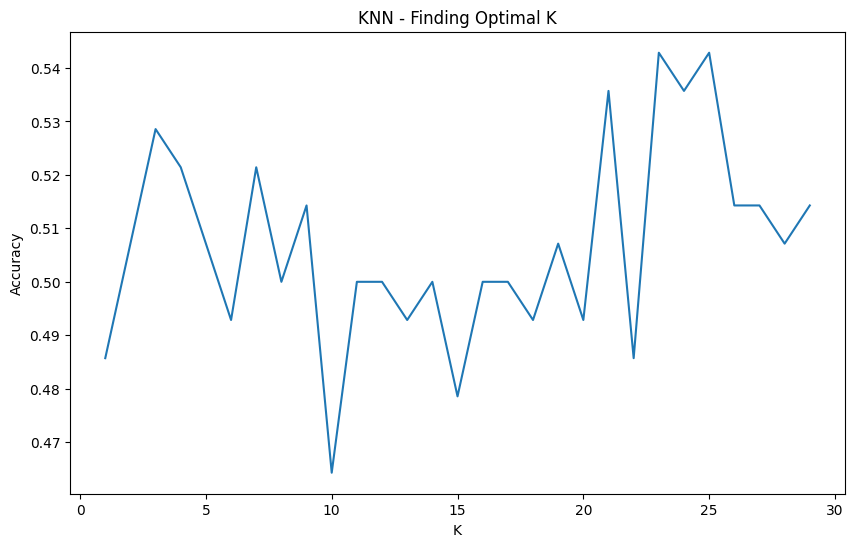

Optimal K: 25


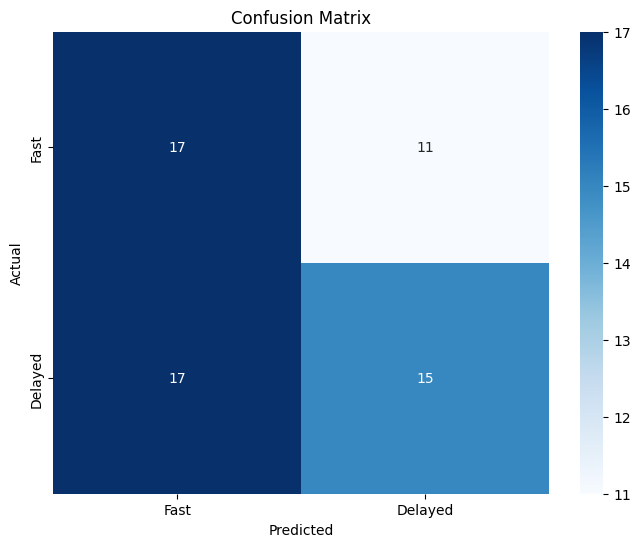

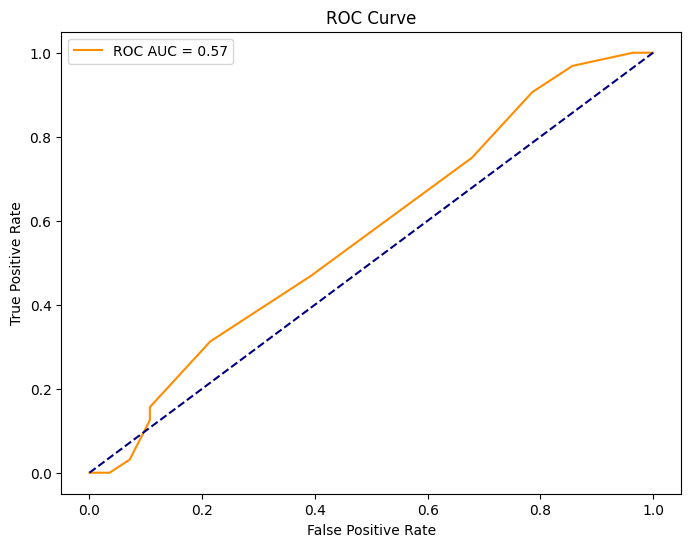

Accuracy: 0.5333
Precision: 0.5769
Recall: 0.4688
F1 Score: 0.5172

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.61      0.55        28
           1       0.58      0.47      0.52        32

    accuracy                           0.53        60
   macro avg       0.54      0.54      0.53        60
weighted avg       0.54      0.53      0.53        60


Decision Tree Classifier
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


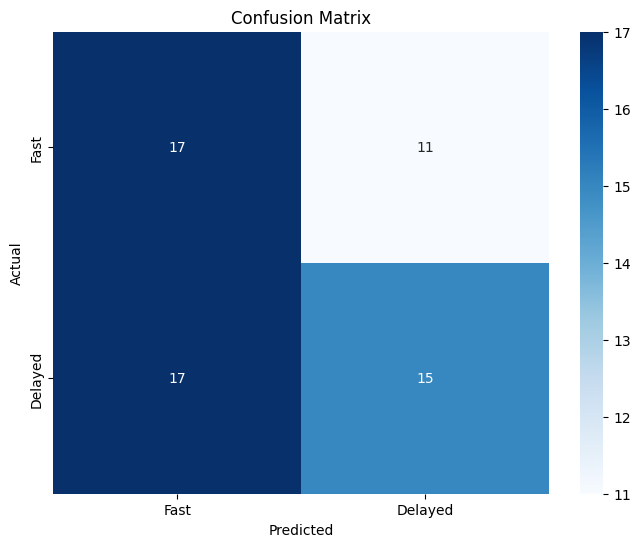

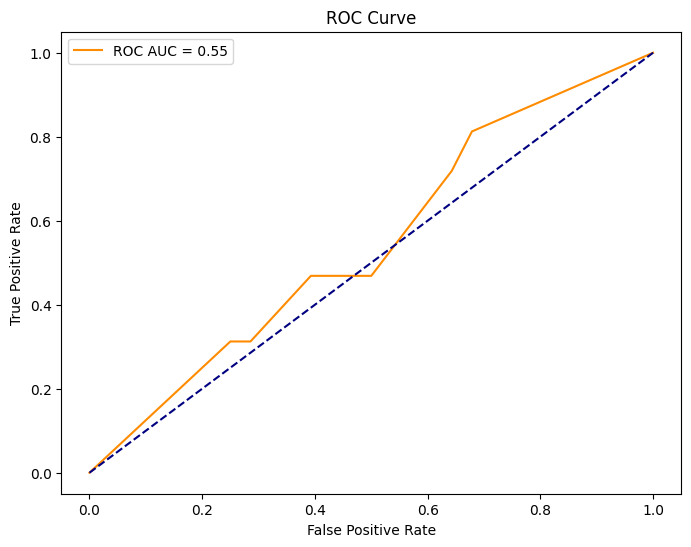

Accuracy: 0.5333
Precision: 0.5769
Recall: 0.4688
F1 Score: 0.5172

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.61      0.55        28
           1       0.58      0.47      0.52        32

    accuracy                           0.53        60
   macro avg       0.54      0.54      0.53        60
weighted avg       0.54      0.53      0.53        60


Model Comparison
           Model  Accuracy  Precision   Recall  F1 Score   ROC AUC
0    Naive Bayes  0.466667   0.500000  0.34375  0.407407  0.514509
1            KNN  0.533333   0.576923  0.46875  0.517241  0.569196
2  Decision Tree  0.533333   0.576923  0.46875  0.517241  0.545759


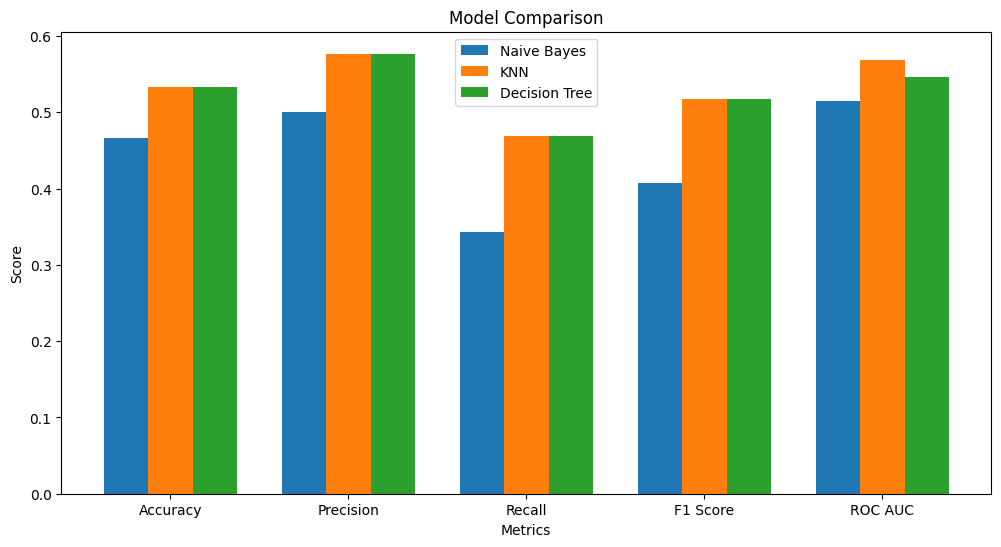

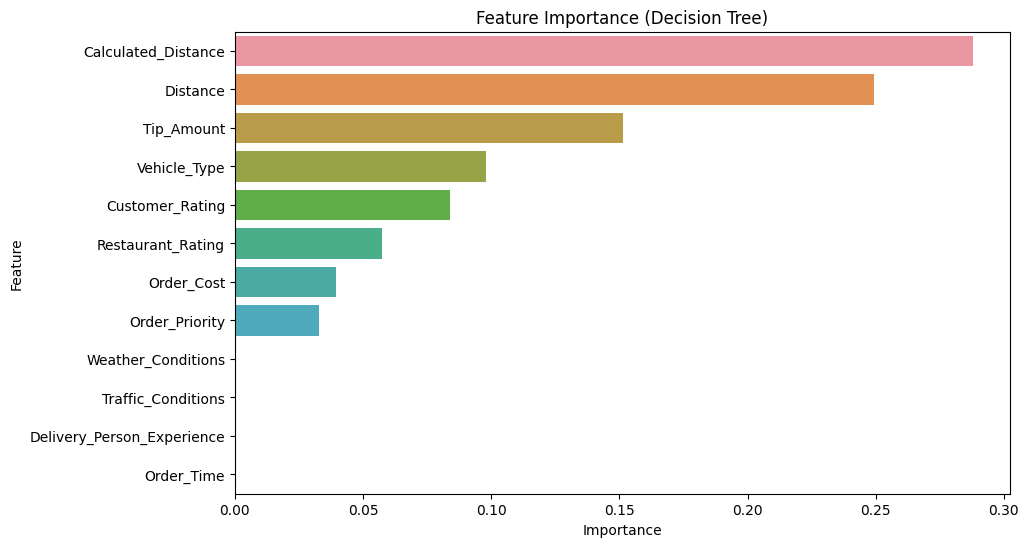


FINAL SUMMARY: This model shows that KNN (K=25) and Decision Tree (max_depth=5) both achieved 53.3% accuracy, outperforming Naive Bayes (46.7%). While precision was moderate (57.7% for both top models), recall rates were lower (46.9%), indicating challenges in identifying delayed deliveries. The ROC AUC scores were similarly normal (KNN: 0.569, Decision Tree: 0.546), suggesting room for improvement. Key findings show that all models struggled with class imbalance, no model exceeded 54% weighted F1-score, and for better interpretability Decision Tree should be optimized. Some recommendations are to solve class imbalance through sampling techniques, collect more features like traffic patterns, engineer time-based features (e.g., rush hour flags), and consider better methods to boost performance beyond the current 53% accuracy ceiling.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, precision_score, 
                             recall_score, f1_score, roc_curve, auc)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.random.seed(42)
df = pd.read_csv('/kaggle/input/food-delivery-time-prediction-bayes/Food_Delivery_Time_Prediction_Bayes.csv')
print("Missing values before cleaning:")
print(df.isnull().sum())
df.ffill(inplace=True)
df.bfill(inplace=True)
print("\nInfinite values before cleaning:")
print(np.isinf(df.select_dtypes(include=[np.number])).sum())

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)
def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    radius = 6371  # km
    return radius * c

df['Customer_Lat'] = df['Customer_Location'].str.extract(r'\(([^,]+),')[0].astype(float)
df['Customer_Lon'] = df['Customer_Location'].str.extract(r',\s*([^)]+)')[0].astype(float)
df['Restaurant_Lat'] = df['Restaurant_Location'].str.extract(r'\(([^,]+),')[0].astype(float)
df['Restaurant_Lon'] = df['Restaurant_Location'].str.extract(r',\s*([^)]+)')[0].astype(float)

df['Calculated_Distance'] = df.apply(
    lambda row: haversine_distance(
        row['Customer_Lat'], row['Customer_Lon'],
        row['Restaurant_Lat'], row['Restaurant_Lon']
    ), axis=1
)

median_delivery_time = df['Delivery_Time'].median()
df['Delivery_Status'] = np.where(df['Delivery_Time'] <= median_delivery_time, 0, 1)

categorical_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 
                    'Order_Time', 'Vehicle_Type']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
continuous_cols = ['Distance', 'Delivery_Person_Experience', 'Restaurant_Rating', 
                   'Customer_Rating', 'Order_Cost', 'Tip_Amount', 'Calculated_Distance']

scaler = MinMaxScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])
features = ['Distance', 'Weather_Conditions', 'Traffic_Conditions', 
            'Delivery_Person_Experience', 'Order_Priority', 'Order_Time', 
            'Vehicle_Type', 'Restaurant_Rating', 'Customer_Rating', 
            'Order_Cost', 'Tip_Amount', 'Calculated_Distance']

X = df[features]
y = df['Delivery_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fast', 'Delayed'], yticklabels=['Fast', 'Delayed'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return accuracy, precision, recall, f1, roc_auc
print("\n" + "="*50)
print("Naive Bayes Classifier")
print("="*50)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_metrics = evaluate_model(nb_model, X_test, y_test)
print("\n" + "="*50)
print("K-Nearest Neighbors (KNN) Classifier")
print("="*50)
k_values = list(range(1, 30))
k_scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train, y_train, cv=5).mean() for k in k_values]

plt.figure(figsize=(10, 6))
plt.plot(k_values, k_scores)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('KNN - Finding Optimal K')
plt.show()

optimal_k = k_values[np.argmax(k_scores)]
print(f"Optimal K: {optimal_k}")
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train, y_train)
knn_metrics = evaluate_model(knn_model, X_test, y_test)
print("\n" + "="*50)
print("Decision Tree Classifier")
print("="*50)
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_dt_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
best_dt_model.fit(X_train, y_train)
dt_metrics = evaluate_model(best_dt_model, X_test, y_test)
print("\n" + "="*50)
print("Model Comparison")
print("="*50)
comparison_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'KNN', 'Decision Tree'],
    'Accuracy': [nb_metrics[0], knn_metrics[0], dt_metrics[0]],
    'Precision': [nb_metrics[1], knn_metrics[1], dt_metrics[1]],
    'Recall': [nb_metrics[2], knn_metrics[2], dt_metrics[2]],
    'F1 Score': [nb_metrics[3], knn_metrics[3], dt_metrics[3]],
    'ROC AUC': [nb_metrics[4], knn_metrics[4], dt_metrics[4]],
})
print(comparison_df)
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
x = np.arange(len(metrics))
width = 0.25

plt.bar(x - width, comparison_df.iloc[0, 1:], width, label='Naive Bayes')
plt.bar(x, comparison_df.iloc[1, 1:], width, label='KNN')
plt.bar(x + width, comparison_df.iloc[2, 1:], width, label='Decision Tree')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.show()
if hasattr(best_dt_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': best_dt_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance (Decision Tree)')
    plt.show()

print("\nFINAL SUMMARY: This model shows that KNN (K=25) and Decision Tree (max_depth=5) both achieved 53.3% accuracy, outperforming Naive Bayes (46.7%). While precision was moderate (57.7% for both top models), recall rates were lower (46.9%), indicating challenges in identifying delayed deliveries. The ROC AUC scores were similarly normal (KNN: 0.569, Decision Tree: 0.546), suggesting room for improvement. Key findings show that all models struggled with class imbalance, no model exceeded 54% weighted F1-score, and for better interpretability Decision Tree should be optimized. Some recommendations are to solve class imbalance through sampling techniques, collect more features like traffic patterns, engineer time-based features (e.g., rush hour flags), and consider better methods to boost performance beyond the current 53% accuracy ceiling.")